In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)
from datetime import datetime
from dateutil.relativedelta import relativedelta
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


## Issuance 

In [2]:
kin_total = 10000000000000
kin_public = int(kin_total * .1)
kin_team_option = int(kin_total * .3)
kin_foundation_option = int(kin_total * .6)

## Supply Schedule

In [3]:
kin_team_unlock = 0.1 * kin_team_option # 10% per quarter
kin_foundation_unlock_rate = 0.2 # 20% per year

## Inflation Rate

In [4]:
inflation_rate = [0.3,0.185,0.125,0.089,0.065,0.049,0.037,0.029,0.022,0.018,0.082] # inflation rate per year

## ICO Kin valuation

In [5]:
# 1B is the valuation in 2015, when Tencent invested with this valuation, and we assume a 20% yearly growth
kik_valuation = 10000000000 * 1.2 * 1.2 
kin_value = kik_valuation * 0.1 / kin_public  # 0.1 since only 10% of total tokens are sold in public
kin_rise = 0.6 # assume Kin rise 60% per year

# Analysis

In [6]:
def get_inflation_rate(year):
    index = int(year)
    frac = year - index
    frac = 0.25
    if index > len(inflation_rate):
        rate = inflation_rate[-1] * frac
    else:
        rate = inflation_rate[index] * frac
    return rate

In [7]:
initial_setting = {
    "kin_foundation_option": kin_foundation_option,
    "kin_foundation_unlock_rate": kin_foundation_unlock_rate,
    "kin_team_option": kin_team_option,
    "kin_team_unlock": kin_team_unlock,
    "kin_value": kin_value,
    "kin_rise": kin_rise,
    "kin_public": kin_public,
}

In [8]:
def valuation_by_year(current_data, year):
    current_data = deepcopy(current_data)
    kin_team_unlock = current_data["kin_team_unlock"]
    kin_team_option = current_data["kin_team_option"]
    kin_foundation_option = current_data["kin_foundation_option"]
    kin_foundation_unlock_rate = current_data["kin_foundation_unlock_rate"]
    kin_value = current_data["kin_value"]
    kin_rise = current_data["kin_rise"]
    kin_public = current_data["kin_public"]
    new_supply = 0
    quarter = year * 4
    if kin_team_option > 0:
        new_unlock = min(kin_team_unlock * quarter, kin_team_option)
        new_supply += new_unlock
        kin_team_option -= new_unlock
    foundation_option_remainder = kin_foundation_option * pow(0.8, min(year, 1)) #at most 1, or the frac part
    foundation_supply = kin_foundation_option - foundation_option_remainder
    new_supply += foundation_supply
    kin_foundation_option = foundation_option_remainder
    kin_public += new_supply
    kin_public = kin_public * (1 + get_inflation_rate(year))
    kin_value = kin_value * (1 + kin_rise * min(year, 1))
    current_data.update({
        "kin_team_option": kin_team_option,
        "kin_foundation_option": kin_foundation_option,
        "kin_public": kin_public,
        "kin_value": kin_value
    })
    return current_data

In [9]:
def valuation(initial_setting=initial_setting, start_date=datetime(2017,9,30), quarter=0):
    d = start_date + relativedelta(months=quarter)
    year = quarter / 4. # let's use year to calculate
    years = int(year)
    frac = year - years
    data = initial_setting
    for i in range(1, years+1):
        data = valuation_by_year(data, i)
    if frac > 0:
        data = valuation_by_year(data, frac)
    initial_setting = data
    kin_team_unlock = initial_setting["kin_team_unlock"]
    kin_team_option = initial_setting["kin_team_option"]
    kin_foundation_option = initial_setting["kin_foundation_option"]
    kin_foundation_unlock_rate = initial_setting["kin_foundation_unlock_rate"]
    kin_value = initial_setting["kin_value"]
    kin_rise = initial_setting["kin_rise"]
    kin_public = initial_setting["kin_public"]
    return d, kin_public, kin_value, kin_public * kin_value, kin_team_option, kin_foundation_option

In [10]:
quarters = 40
dataframes = [valuation(quarter=i) for i in range(quarters)]

## Market Price

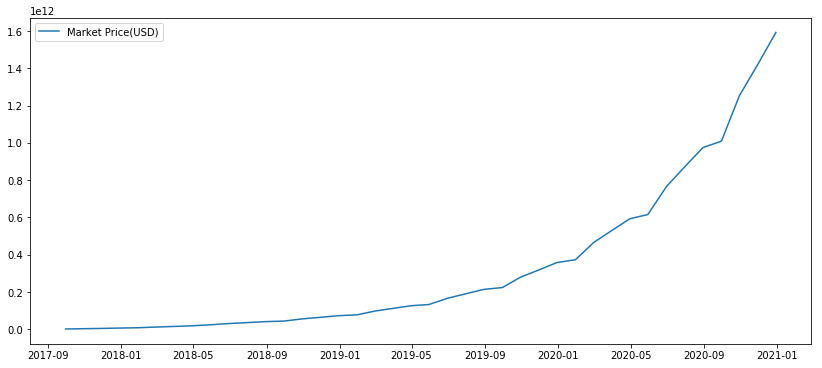

In [11]:
p = plt.plot([x[0] for x in dataframes], [x[3] for x in dataframes])
plt.legend((p[0], ), ("Market Price(USD)",))

## #Kin Available

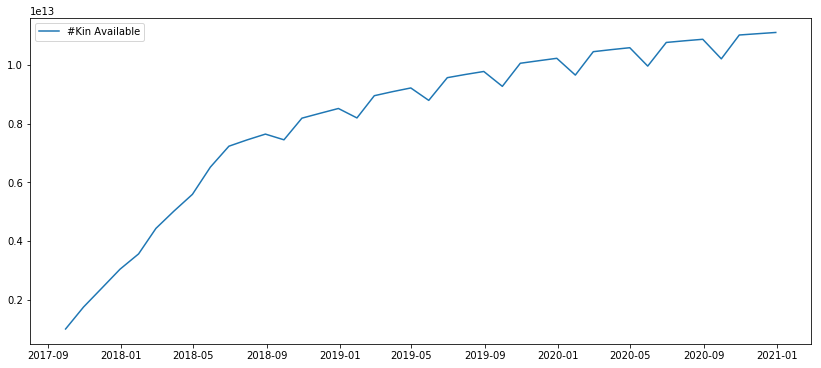

In [12]:
p = plt.plot([x[0] for x in dataframes], [x[1] for x in dataframes])
plt.legend((p[0], ), ("#Kin Available",))

In [13]:
## Kin Price

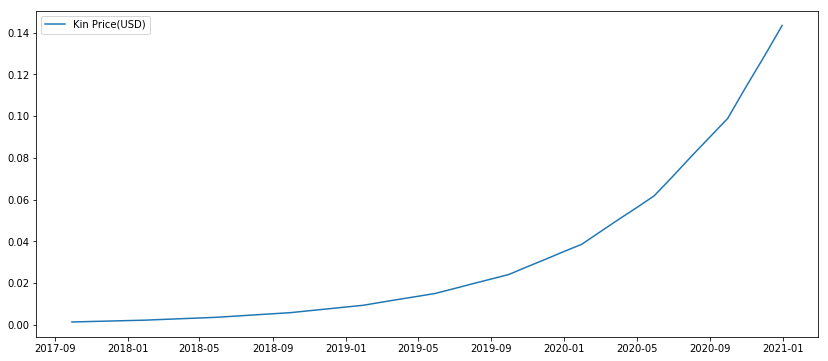

In [14]:
p = plt.plot([x[0] for x in dataframes], [x[2] for x in dataframes])
plt.legend((p[0], ), ("Kin Price(USD)",))

In [15]:
def show_bar(kin_public, kin_team_option, kin_foundation_option):
    N = len(kin_public)
    p1 = plt.bar(np.arange(N), kin_public)
    p2 = plt.bar(np.arange(N), kin_foundation_option, bottom=kin_public)
    p3 = plt.bar(np.arange(N), kin_team_option, bottom=kin_foundation_option)
    plt.legend((p1[0], p2[0], p3[0]), ('#public', '#foundation', '#Team'))

In [16]:
kin_publics = [x[1] for x in dataframes]
kin_team_options = [x[-2] for x in dataframes]
kin_foundation_options = [x[-1] for x in dataframes]

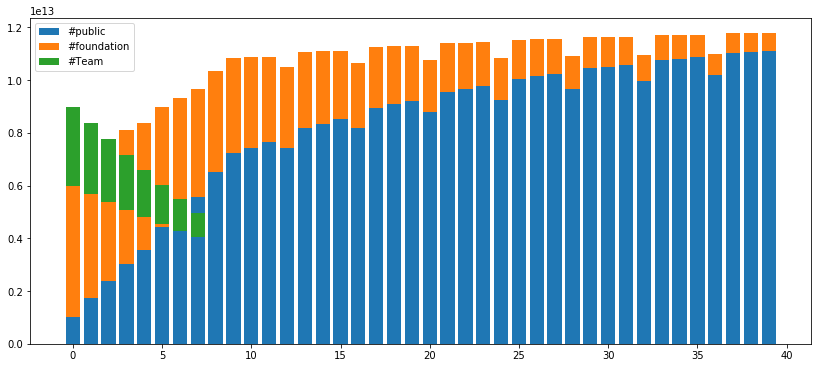

In [17]:
show_bar(kin_publics, kin_team_options, kin_foundation_options)